<div class="alert alert-block alert-info">
<b>Deadline:</b> May 31, 2023 (Wednesday) 23:00
</div>

# Exercise 1. Few-shot learning with Prototypical Networks

The goal of the exercise is to get familiar with methods that can solve few-shot classification tasks. In this noteboook, we will implement Prototypical Networks. We recommend you to read the original paper by [Snell et al, (2017)](https://arxiv.org/pdf/1703.05175.pdf) before doing this assignment.

In [33]:
# We will use interactive figures in this notebook
%matplotlib notebook

In [34]:
skip_training = True  # Set this flag to True before validation and submission

In [35]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [36]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

import tools
import tests

In [37]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [38]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [39]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Omniglot data

We will use Omniglot data for training. Omniglot is a collection of 19280 images of 964 characters from 30 alphabets. There are 20 images for each of the 964 characters in the dataset.

In [40]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.Omniglot(root=data_dir, download=True, transform=transform)

Files already downloaded and verified


In [41]:
# Let us plot some samples from the dataset.
x, y = dataset[0]  # x is the image, y is the label (character)
print(x.shape, y)

torch.Size([1, 105, 105]) 0


<IPython.core.display.Javascript object>


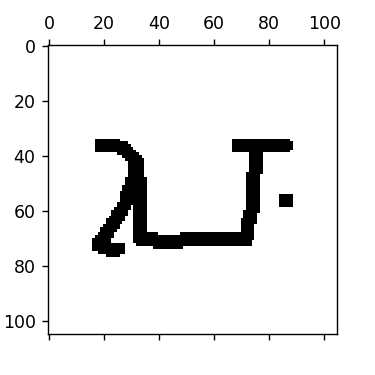

In [42]:
fig, ax = plt.subplots(1, figsize=(3, 3))
ax.matshow(1-x[0], cmap=plt.cm.Greys)

## Custom data loader for the few-shot learning task

The task of few-shot learning is to learn a classification task from a few training examples. In this notebook, we will consider $n$-way $k$-shot classification problems, when each classification problem has $n$ clases with $k$ examples per class in the training dataset.

We take the meta-learning approach, in which we learn how to learn new ($N$-way $k$-shot classification) tasks using multiple training examples of tasks. Thus, in the meta-learning approach, a single "training example" is one learning (e.g. classification) task which comes from a distribution of tasks that we create using the Omniglot dataset. 

We perform meta-learning using **episodic training**. In each episode, we process one training task or a mini-batch of tasks. Each tasks contains two datasets:
* *support set*, which is used to build a classifier,
* *query set*, which is used to test the accuracy of the built classifier.

In order to load such training examples in the training loop, we build a custom dataloader on top of the `Omniglot` dataset available in pytorch.

In [43]:
class OmniglotFewShot(Dataset):
    """Omniglot data set for few-shot learning.

    Args:
      root (string): Root directory to put the data.
      n_support (int): Number of support samples in each training task.
      n_query (int): Number of query samples in each training task.
      transform (callable): Transforms applied to Omniglot images. We rescale them to 28x28,
          convert to tensors and invert so that image backround is encoded as 0 (original Omniglot images have
          background encoded as 1).
      mix: If True, all examples can be used either as support or query examples. If False, the first
          n_support images are always used as support examples and the following n_query images are used
          as query examples.
      train: If True, use training set. If False, use test set.
    """
    def __init__(self, root, n_support, n_query,
                 transform=transforms.Compose([
                     transforms.Resize(28),
                     transforms.ToTensor(),
                     transforms.Lambda(lambda x: 1-x),
                 ]),
                 mix=False,  # Mix support and query examples
                 train=True
                ):

        assert n_support + n_query <= 20, "Omniglot contains only 20 images per character."
        self.n_support = n_support
        self.n_query = n_query
        self.mix = mix
        self.train = train  # training set or test set
        
        self._omniglot = torchvision.datasets.Omniglot(root=root, download=True, transform=transform)
        
        self.character_classes = character_classes = np.array([
            character_class for _, character_class in self._omniglot._flat_character_images
        ])
        
        n_classes = max(character_classes)
        self.indices_for_class = {
            i: np.where(character_classes == i)[0].tolist()
            for i in range(n_classes)
        }
        
        np.random.seed(1)
        rp = np.random.permutation(n_classes)
        if train:
            self.used_classes = rp[:770]
        else:
            self.used_classes = rp[770:]
        
    def __getitem__(self, index):
        """
        Returns:
          support_query of shape (n_support+n_query, 1, height, width):
                      support_query[:n_support] is the support set
                      support_query[n_support:] is the query set
        """
        class_ix = self.used_classes[index]
        indices = self.indices_for_class[class_ix]
        if self.mix:
            indices = np.random.permutation(indices)

        indices = indices[:self.n_support+self.n_query]  # First support, then query
        support_query = torch.stack([self._omniglot[ix][0] for ix in indices])

        return support_query

    def __len__(self):
        return len(self.used_classes)

One sample from the dataset represents one class which consists of `n_support` support samples and `n_query` query samples.

In [44]:
dataset = OmniglotFewShot(root=data_dir, n_support=1, n_query=3, train=True)
support_query = dataset[0]
print(support_query.shape)

Files already downloaded and verified
torch.Size([4, 1, 28, 28])


We can now build data for $n$-way $k$-shot classification tasks using the following data loader. Each mini-batch that this data loader produces is one $n$-way $k$-shot classification task. In principles, we could include more tasks into each mini-batch but we do not do it in this notebok.

In [45]:
n_way = 5
trainloader = DataLoader(dataset=dataset, batch_size=n_way, shuffle=True, pin_memory=True)

for support_query in trainloader:
    print(support_query.shape)
    # support_query is (n-way, n_support+n_query, 1, 28, 28)
    break

torch.Size([5, 4, 1, 28, 28])


# Prototypical networks

## The embedding CNN

We first build a convolutional neural network that embeds images into a lower-dimensional space.

The exact architecture is not important in this exercise but the following architecture worked for us:
* Four blocks with the following layers:
    * `Conv2d` layer with kernel size 3 and 64 output channels, followed by `BatchNorm2d`, ReLU and 2d max pooling (with kernel 2 and stride 2).
* A fully-connected layer with 64 output features.

In [46]:
class CNN(nn.Module):
    # YOUR CODE HERE
    # raise NotImplementedError()

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)

        # 64 x 3 x 3 = 576
        self.fc = nn.Linear(576, 64)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        #print(x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        #print(x.shape)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        #print(x.shape)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc(x)
        #print(x.shape)
        return x

In [47]:
def test_CNN_shapes():
    net = CNN()

    x = torch.randn(2, 1, 28, 28)
    y = net(x)
    assert y.shape == torch.Size([2, 64]), f"Wrong y.shape: {y.shape}"
    print('Success')

test_CNN_shapes()

Success


## One episode of training

In the cell below, you need to implement building a computational graph for one episode of training of Prototypical Networks.

The required steps:
* Use the provided network to embed both support and query examples.
* Compute one prototype per class using the support set. The prototypes are the mean values of the embeddings of the samples from the same class.
* Compute the log-probabilities that the query samples belong to one of the n classes.
  The probabilities are softmax of the negative squared Euclidean distance from an embedded sample to a class prototype.
* Compute the negative log-likelihood loss using the query samples.

Notes:
* Try to avoid using for-loops. This will result in faster training and (possibly) better accuracy.
* One reason why for-loops can affect training is batch normalization. If you compute the embeddings in a for-loop, the running estimates of the batch norm statistics will be different compared to computing the embeddings with one call of the CNN forward function.
* **Your implementation should work for any values of `n_way`, `n_support`, `n_query` and for input images of any resolution.**

In [48]:
def episode_pn(net, support_query, n_support):
    """Build a computational graph for one episode of training of prototypical networks.
    
    Args:
      net: An embedding network which takes as inputs tensors of shape (batch_size, n_channels, height, width)
           and which outputs a tensor of shape (batch_size, n_features).
      support_query of shape (n_way, n_support+n_query, 1, height, width):
                      support_query[:, :n_support] is the support set
                      support_query[:, n_support:] is the query set
    
    Returns:
      loss (scalar tensor): The negative log-likelihood loss.
      accuracy (float): The classification accuracy on the given example (needed for tracking the progress).
      outputs of shape (n_way, n_query, n_way): Logits (log-softmax) of the probabilities of query classes
          belonging to one of the n classes. The first dimension corresponds to the true class, the last
          dimension corresponds to predicted classes.
    """
    # YOUR CODE HERE
    # raise NotImplementedError()


    # https://github.com/jakesnell/prototypical-networks/blob/master/protonets/models/few_shot.py
    
    # n_channels = 1
    n_way, n_samples, n_channels, height, width = support_query.shape # (n_way, n_support+n_query, 1, height, width)
    #print(support_query.shape)
    n_query = n_samples - n_support
    
    # Split support and query sets
    support_set = support_query[:, :n_support] # shape (n_way, n_support, 1, height, width)
    #print(support_set.shape)
    query_set = support_query[:, n_support:] # shape (n_way, n_query, 1, height, width)
    #print(query_set.shape)

    # Embedding support and query sets
    support_embedded = support_set.reshape(-1, n_channels, height, width) # Shape: (n_way * n_support, 1, height, width)
    #print(support_embedded.shape)
    query_embedded = query_set.reshape(-1, n_channels, height, width) # Shape: (n_way * n_query, 1, height, width)
    #print(query_embedded.shape)

    # Use the provided network to embed both support and query examples.
    support_embeddings = net(support_embedded)  # Shape: (n_way * n_support, n_features) where n_features = 64
    #print(support_embeddings.shape)
    query_embeddings = net(query_embedded)  # Shape: (n_way * n_query, n_features) where n_features = 64
    #print(query_embeddings.shape)
    
    
    # Compute one prototype per class using the support set. 
    # The prototypes are the mean values of the embeddings of the samples from the same class.
    
    prototypes = support_embeddings.reshape(n_way, n_support, -1).mean(dim=1)  # Shape: (n_way, n_features)
    
    # Compute the log-probabilities that the query samples belong to one of the n classes.
    # The probabilities are softmax of the negative squared Euclidean distance from an embedded sample to a class prototype.
    dists = torch.cdist(query_embeddings, prototypes, p=2)  # Shape: (n_way * n_query, n_way)

    # Compute the negative log-likelihood loss using the query samples.
    log_probs = F.log_softmax(-dists, dim=1).reshape(n_way, n_query, -1)  # Shape: (n_way, n_query, n_way)
    outputs = log_probs

    # Compute the negative log-likelihood loss
    targets = torch.arange(0, n_way).reshape(n_way, 1, 1).expand(n_way, n_query, 1).long()

    # Compute the negative log-likelihood loss
    loss = -log_probs.gather(2, targets).squeeze().view(-1).mean()

    # Compute accuracy
    _, y_hat = log_probs.max(dim=2)
    accuracy = torch.eq(y_hat, targets.squeeze()).float().mean().item()

    return loss, accuracy, outputs


In [49]:
def test_episode_pn_shapes():
    n_support = 2
    n_query = 4
    n_way = 5
    support_query = torch.randn(n_way, n_support+n_query, 1, 28, 28)

    net = CNN()
    loss, accuracy, outputs = episode_pn(net, support_query, n_support)
    assert loss.shape == torch.Size([]), "Bad loss.shape"
    assert 0. <= float(accuracy) <= 1., "accuracy should be a scalar between 0 and 1."
    assert outputs.shape == torch.Size([n_way, n_query, n_way]), f"Bad outputs.shape: {outputs.shape}"
    print('Success')

test_episode_pn_shapes()

Success


In [50]:
# This cell tests episode_pn()
def test_episode_pn_hidden(episode_pn):
    n_support = 2
    n_query = 2
    n_way = 5
  
    sq = torch.tensor([
        [0.,   2.,  1.,  2.],
        [1.,   3.,  2.,  3.],
        [2.,   4.,  3.,  4.],
        [3.,   5.,  4.,  5.],
        [4.,   6.,  5.,  6.],
    ]) # (n_way, n_support+n_query)
    support_query = sq.view(n_way, n_support+n_query, 1, 1, 1).repeat(1, 1, 1, 28, 28)

    class _CNN(nn.Module):
        def forward(self, x):
            out = x[:, 0, 0, 0].view(-1, 1).repeat(1, 64)
            return out

    net = _CNN()
    loss, accuracy, outputs = episode_pn(net, support_query, n_support)

    print('outputs:\n', outputs)
    expected_d2 = torch.tensor([
        [[    0.,   -64.,  -256.,  -576., -1024.],
         [  -64.,     0.,   -64.,  -256.,  -576.]],

        [[  -64.,     0.,   -64.,  -256.,  -576.],
         [ -256.,   -64.,     0.,   -64.,  -256.]],

        [[ -256.,   -64.,     0.,   -64.,  -256.],
         [ -576.,  -256.,   -64.,     0.,   -64.]],

        [[ -576.,  -256.,   -64.,     0.,   -64.],
         [-1024.,  -576.,  -256.,   -64.,     0.]],

        [[-1024.,  -576.,  -256.,   -64.,     0.],
         [-1536.,  -960.,  -512.,  -192.,     0.]]
    ])
    expected_d = torch.tensor([
        [[-3.3552e-04, -8.0003e+00, -1.6000e+01, -2.4000e+01, -3.2000e+01],
         [-8.0007e+00, -6.7080e-04, -8.0007e+00, -1.6001e+01, -2.4001e+01]],

        [[-8.0007e+00, -6.7080e-04, -8.0007e+00, -1.6001e+01, -2.4001e+01],
         [-1.6001e+01, -8.0007e+00, -6.7092e-04, -8.0007e+00, -1.6001e+01]],

        [[-1.6001e+01, -8.0007e+00, -6.7092e-04, -8.0007e+00, -1.6001e+01],
         [-2.4001e+01, -1.6001e+01, -8.0007e+00, -6.7080e-04, -8.0007e+00]],

        [[-2.4001e+01, -1.6001e+01, -8.0007e+00, -6.7080e-04, -8.0007e+00],
         [-3.2000e+01, -2.4000e+01, -1.6000e+01, -8.0003e+00, -3.3552e-04]],

        [[-3.2000e+01, -2.4000e+01, -1.6000e+01, -8.0003e+00, -3.3552e-04],
         [-3.2000e+01, -2.4000e+01, -1.6000e+01, -8.0003e+00, -3.3552e-04]]
    ])
    #print('expected outputs:\n', expected_d2)
    assert torch.allclose(outputs, expected_d, rtol=1e-4, atol=10e-4) \
        or torch.allclose(outputs, expected_d2, rtol=1e-4, atol=10e-4), "outputs does not match expected value"

    print('loss:', loss)
    expected_d2 = torch.tensor(25.6000)
    expected_d = torch.tensor(3.2005)
    #print('expected loss:', expected_d2)
    assert torch.allclose(loss, expected_d2, rtol=1e-4, atol=10e-4) \
        or torch.allclose(loss, expected_d, rtol=1e-4, atol=10e-4), "loss does not match expected value"

    print('accuracy:', accuracy)
    expected = .6
    print('expected accuracy:', expected)
    assert np.allclose(float(accuracy), expected), "accuracy does not match expected value"

    print('Success')

test_episode_pn_hidden(episode_pn)

outputs:
 tensor([[[-3.3552e-04, -8.0003e+00, -1.6000e+01, -2.4000e+01, -3.2000e+01],
         [-8.0007e+00, -6.7080e-04, -8.0007e+00, -1.6001e+01, -2.4001e+01]],

        [[-8.0007e+00, -6.7080e-04, -8.0007e+00, -1.6001e+01, -2.4001e+01],
         [-1.6001e+01, -8.0007e+00, -6.7092e-04, -8.0007e+00, -1.6001e+01]],

        [[-1.6001e+01, -8.0007e+00, -6.7092e-04, -8.0007e+00, -1.6001e+01],
         [-2.4001e+01, -1.6001e+01, -8.0007e+00, -6.7080e-04, -8.0007e+00]],

        [[-2.4001e+01, -1.6001e+01, -8.0007e+00, -6.7080e-04, -8.0007e+00],
         [-3.2000e+01, -2.4000e+01, -1.6000e+01, -8.0003e+00, -3.3552e-04]],

        [[-3.2000e+01, -2.4000e+01, -1.6000e+01, -8.0003e+00, -3.3552e-04],
         [-3.2000e+01, -2.4000e+01, -1.6000e+01, -8.0003e+00, -3.3552e-04]]])
loss: tensor(3.2005)
accuracy: 0.6000000238418579
expected accuracy: 0.6
Success


## Train Prototypical Networks

In the cell below, we defing the data loaders.

Note:
* Increasing `num_workers` speeds up the training procedure. However, `num_workers > 0` does not work on some systems.

In [51]:
# Prepare dataloader
n_support = 1
n_query = 3
n_way = 5
trainset = OmniglotFewShot(root=data_dir, n_support=n_support, n_query=n_query, train=True, mix=True)
trainloader = DataLoader(dataset=trainset, batch_size=n_way, shuffle=True, pin_memory=True, num_workers=3)

testset = OmniglotFewShot(root=data_dir, n_support=n_support, n_query=n_query, train=False, mix=True)
testloader = DataLoader(dataset=testset, batch_size=n_way, shuffle=False, pin_memory=True, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
# Create the model
net = CNN()
net.to(device)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): 

### Training loop

Implement the training loop in the cell below.

Recommended hyperparameters:
* Adam optimizer with learning rate 0.001. It helps to anneal the learning rate to 0.00001 during training (but it is not needed to pass the tests).

Hints:
* We recommended you to track training and test accuracies returned by function `episode_pn()`.
* During training, both training and test accuracies should reach at least the level of 0.96. Note that we sample a limited number of tasks to compute the accuracies and therefore the accuracy values may fluctuate.
* **Do not forget to set the network into the training mode during training and to evaluation mode during evaluation.**

In [53]:
from torch.optim import Adam

# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    # raise NotImplementedError()

    # Set the hyperparameters
    learning_rate = 0.001
    anneal_lr = True

    # Create the optimizer
    optimizer = Adam(net.parameters(), lr=learning_rate)

    # Set the number of training epochs
    num_epochs = 20

    # Training loop
    for epoch in range(num_epochs):
        # Set the model to training mode
        net.train()
        
        # Track training accuracy
        train_accuracy = 0.0
        
        for support_query in trainloader:
            # Move support_query to the device
            support_query = support_query.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Perform one episode of training
            loss, accuracy, _ = episode_pn(net, support_query, n_support)
            
            # Backpropagation
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Track the training accuracy
            train_accuracy += accuracy
        
        # Compute the average training accuracy
        train_accuracy /= len(trainloader)
        
        # Set the model to evaluation mode
        net.eval()
        
        # Track test accuracy
        test_accuracy = 0.0
        
        for support_query in testloader:
            # Move support_query to the device
            support_query = support_query.to(device)
            
            # Perform one episode of testing
            _, accuracy, _ = episode_pn(net, support_query, n_support)
            
            # Track the test accuracy
            test_accuracy += accuracy
        
        # Compute the average test accuracy
        test_accuracy /= len(testloader)
        
        # Anneal the learning rate if specified
        if anneal_lr:
            new_learning_rate = learning_rate * (0.1 ** (epoch // 10))
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_learning_rate
        
        # Print the training progress
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

In [54]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(net, '1_pn.pth', confirm=False)

In [55]:
if skip_training:
    net = CNN()
    tools.load_model(net, '1_pn.pth', device)

Model loaded from 1_pn.pth.


In [56]:
# This cell tests the accuracy of your model
def test_accuracy(net, testloader):
    n_support = 1
    n_query = 3
    net.eval()
    with torch.no_grad():
        test_accs = []
        for i, support_query in enumerate(testloader):
            _, acc, outputs = episode_pn(net, support_query.to(device), n_support)
            # My estimation of accuracy
            n_way = support_query.size(0)
            targets = torch.arange(n_way).view(n_way, 1).repeat(1, n_query).to(device)
            acc = (outputs.argmax(dim=2) == targets).sum().float() / targets.numel()
            test_accs.append(float(acc))
    accuracy = np.mean(test_accs)
    print('accuracy:', accuracy)
    assert accuracy >= 0.9, 'Poor accuracy of the prototypical networks.'
    print('Success')

test_accuracy(net, testloader)

accuracy: 0.9914529919624329
Success


# Test the trained model

In [57]:
# Use one clasification task from the test set
net.eval()
with torch.no_grad():
    support_query = iter(testloader).next()
    _, acc, outputs = episode_pn(net, support_query.to(device), n_support=1)
    print(outputs.argmax(dim=2))

tensor([[0, 3, 0],
        [1, 1, 1],
        [2, 2, 2],
        [3, 3, 3],
        [4, 4, 4]])


## Interactive demo

Please take a look at the demo in [the blog post](https://openai.com/blog/reptile/) about another meta-learning algorithm called Reptile.

In the cell below, you can test your prototypical network in a similar setup. In the first row of the figure below, you can draw new classes (support set) using your mouse. Then, you can create three query examples in the second row of the figure.

<IPython.core.display.Javascript object>


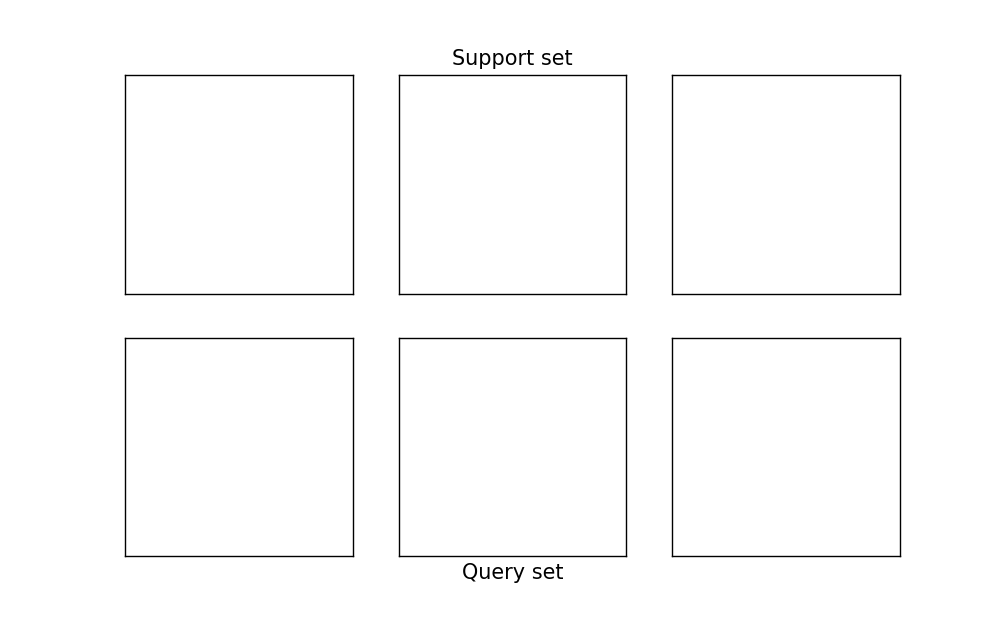

In [58]:
canvas = tests.Canvas()

In the next cell, we classify the images of the query set to one of three classes specified by the support set.
The colors of the frames in the bottom row represent the labels produced by the classifier for the query set.

torch.Size([3, 2, 1, 28, 28])


<IPython.core.display.Javascript object>


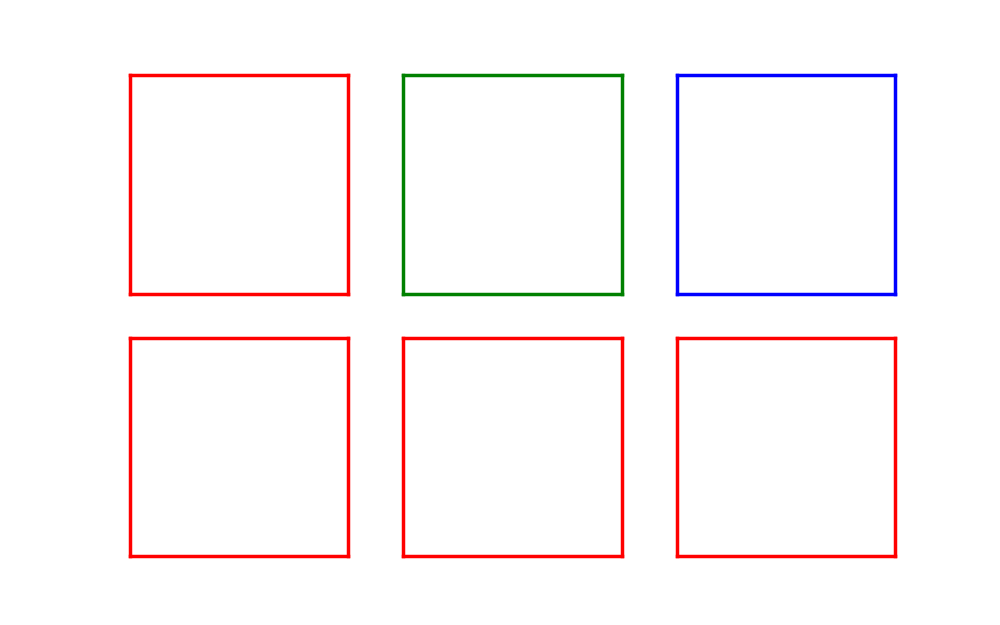

In [59]:
# Convert images into torch tensors
support_query = canvas.get_images()
print(support_query.shape)

net.eval()
with torch.no_grad():
    _, _, outputs = episode_pn(net, support_query.float().to(device), n_support=1)
    # outputs is (n_way, n_query, n_way)
classes = outputs.argmax(dim=2).view(-1)

tests.plot_classification(support_query, classes)

<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

In this exercise, we learned how to train prototypical networks for few-shot learning.